## InceptionV3 - BGR

## InceptionV3 - RGB

## InceptionV3 - RGB & Data Preprocessed

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)
        np.random.shuffle(base_files)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_bgr = cv2.imread(image_path)
            
            # 노이즈 제거
            image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # YUV 컬로 포맷으로 변환
            image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # 히스토그램 평활화 적용
            image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # #RGB로 변환
            image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = 'datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

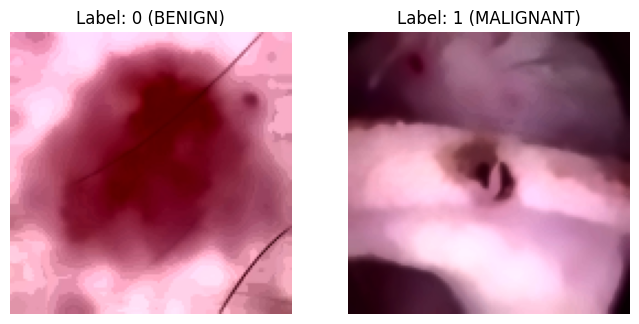

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][1].reshape(128, 128, 3)
sample_image_1 = X[y == 1][1].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape) # 사전학습된 imagenet 사용
    # include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 사전학습된 가중치는 고정

    # 완전 연결 계층
    x = base_model.output # base_model의 출력값
    x = GlobalAveragePooling2D()(x) # Pooling 시킴
    x = Dense(1024, activation='relu')(x) # 완전연결층
    output = Dense(1, activation='sigmoid')(x) # 출력값 생성

    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# Inception 용 전처리
# X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train)
# X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val)
# X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test)

model = create_inceptionv3_model((128, 128, 3)) # 3: RGB
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)
]

#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 15:07:50.552836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7125

2024-07-10 15:07:57.646308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 15s 178ms/step - loss: 0.5878 - accuracy: 0.7125 - val_loss: 0.5862 - val_accuracy: 0.7350
Epoch 2/50
50/50 [==============================] - 4s 88ms/step - loss: 0.3597 - accuracy: 0.8456 - val_loss: 0.5832 - val_accuracy: 0.7600
Epoch 3/50
50/50 [==============================] - 4s 73ms/step - loss: 0.2696 - accuracy: 0.8913 - val_loss: 0.5853 - val_accuracy: 0.7650
Epoch 4/50
50/50 [==============================] - 4s 85ms/step - loss: 0.2144 - accuracy: 0.9281 - val_loss: 0.5720 - val_accuracy: 0.7400
Epoch 5/50
50/50 [==============================] - 4s 72ms/step - loss: 0.1747 - accuracy: 0.9481 - val_loss: 0.7192 - val_accuracy: 0.7050
Epoch 6/50
50/50 [==============================] - 4s 85ms/step - loss: 0.1451 - accuracy: 0.9663 - val_loss: 0.5389 - val_accuracy: 0.7500
Epoch 7/50
50/50 [==============================] - 4s 72ms/step - loss: 0.1069 - accuracy: 0.9831 - val_loss: 0.5922 - val_accuracy: 0.7400
Epoch 8/50
50/50 [====

In [ ]:
model = tf.keras.models.load_model('best_inception_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 15:09:14.939013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 223ms/step - loss: 0.5155 - accuracy: 0.8300
Test Accuracy: 0.8300


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 15:09:22.181535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 270ms/step


#### 결과

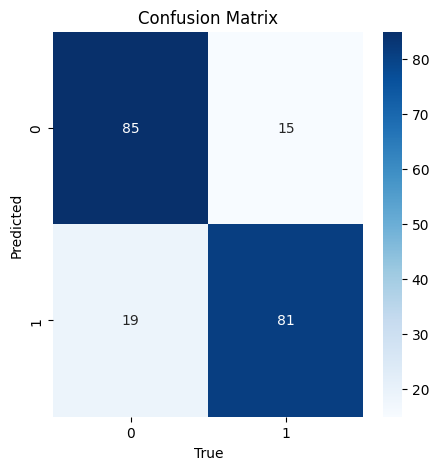

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

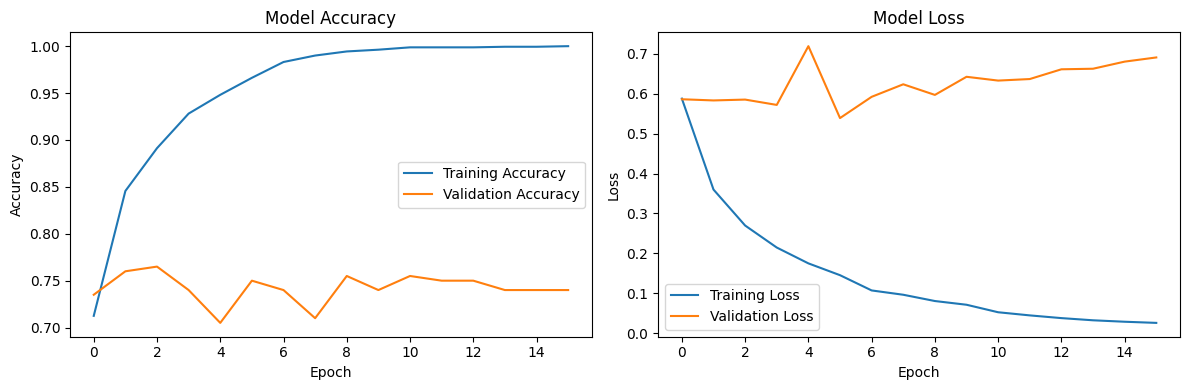

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

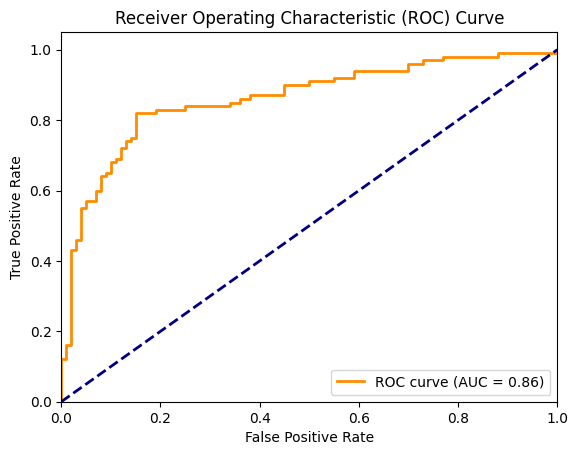

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/RGB'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []  # image data를 모으는 빈 리스트 생성
    labels = []  # image data의 label(class)를 저장할 리스트 생성
    categories = ['BENIGN', 'MALIGNANT']  # 카테고리 종류

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)  # 데이터 구조:
        base_files = os.listdir(base_path)  # category에 맞는 데이터 받아옴

        for idx in range(1000):  # 각 카테고리 별 1000장씩 받아옴
            image_path = os.path.join(base_path, base_files[idx]) # 이미지 경로 받기
            image = cv2.imread(image_path)  # 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            images.append(image)
            labels.append(class_num)

    # 이미지를 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

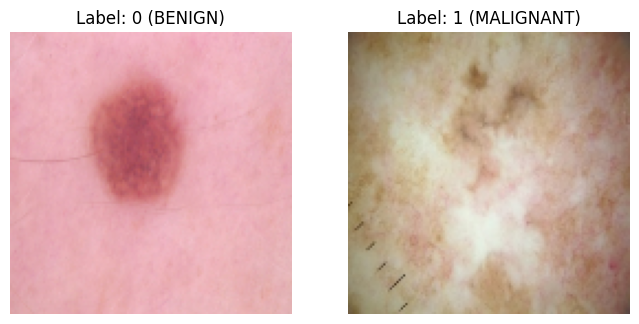

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape) # 사전학습된 imagenet 사용
    # include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 사전학습된 가중치는 고정

    # 완전 연결 계층
    x = base_model.output # base_model의 출력값
    x = GlobalAveragePooling2D()(x) # Pooling 시킴
    x = Dense(1024, activation='relu')(x) # 완전연결층
    output = Dense(1, activation='sigmoid')(x) # 출력값 생성

    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
# Inception 용 전처리
# X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train)
# X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val)
# X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test)

model = create_inceptionv3_model((128, 128, 3)) # 3: RGB
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inceptionV3_rgb_model.h5', save_best_only=True)
]

#### 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 22:56:43.611918: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 22:56:45.551179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7031

2024-07-10 22:56:52.035131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 11s 143ms/step - loss: 0.6084 - accuracy: 0.7031 - val_loss: 0.5960 - val_accuracy: 0.7150
Epoch 2/50
50/50 [==============================] - 4s 80ms/step - loss: 0.4197 - accuracy: 0.8087 - val_loss: 0.5355 - val_accuracy: 0.7800
Epoch 3/50
50/50 [==============================] - 4s 76ms/step - loss: 0.3196 - accuracy: 0.8662 - val_loss: 0.5851 - val_accuracy: 0.7650
Epoch 4/50
50/50 [==============================] - 3s 69ms/step - loss: 0.2709 - accuracy: 0.8944 - val_loss: 0.5442 - val_accuracy: 0.7750
Epoch 5/50
50/50 [==============================] - 4s 78ms/step - loss: 0.2288 - accuracy: 0.9194 - val_loss: 0.5444 - val_accuracy: 0.7850
Epoch 6/50
50/50 [==============================] - 3s 69ms/step - loss: 0.1868 - accuracy: 0.9469 - val_loss: 0.5429 - val_accuracy: 0.7650
Epoch 7/50
50/50 [==============================] - 4s 74ms/step - loss: 0.1639 - accuracy: 0.9581 - val_loss: 0.5480 - val_accuracy: 0.7950
Epoch 8/50
50/50 [====

In [ ]:
model = tf.keras.models.load_model('best_inceptionV3_rgb_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 22:57:37.988208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 230ms/step - loss: 0.4968 - accuracy: 0.8050
Test Accuracy: 0.8050


In [ ]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 22:57:40.952082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 208ms/step


#### 결과

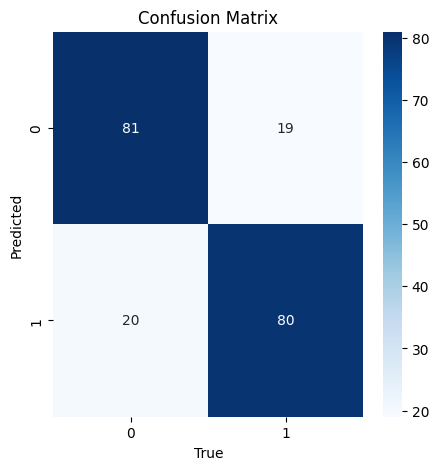

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

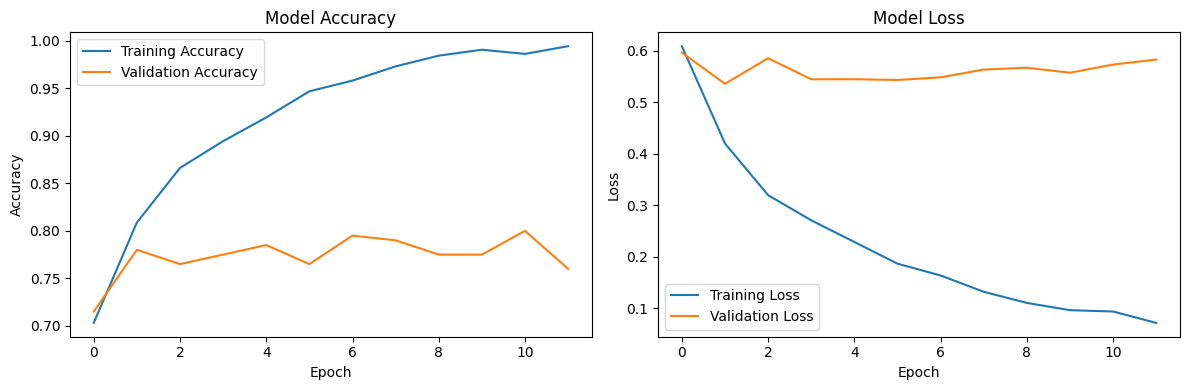

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

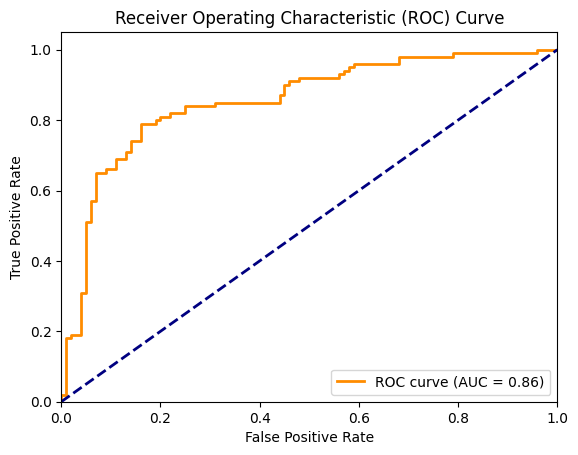

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [15]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/BGR & 전처리 X'

In [16]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [17]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [18]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [19]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_rgb = cv2.imread(image_path)
            
            # # 노이즈 제거
            # image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # # YUV 컬로 포맷으로 변환
            # image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # # 히스토그램 평활화 적용
            # image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # # #RGB로 변환
            # image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [20]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

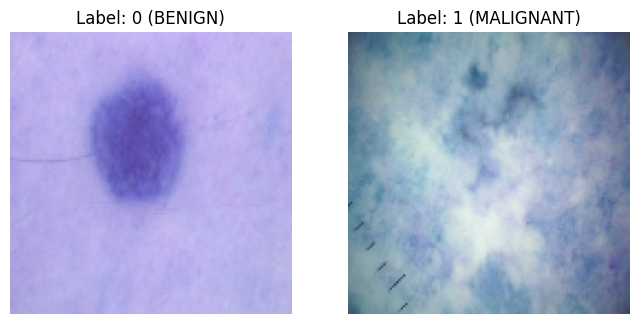

In [21]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [22]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [24]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [25]:
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape) # 사전학습된 imagenet 사용
    # include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 사전학습된 가중치는 고정

    # 완전 연결 계층
    x = base_model.output # base_model의 출력값
    x = GlobalAveragePooling2D()(x) # Pooling 시킴
    x = Dense(1024, activation='relu')(x) # 완전연결층
    output = Dense(1, activation='sigmoid')(x) # 출력값 생성

    model = Model(inputs=base_model.input, outputs=output)

    return model

In [26]:
# Inception 용 전처리
# X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train)
# X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val)
# X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test)

model = create_inceptionv3_model((128, 128, 3)) # 3: RGB
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)
]

#### 학습

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


2024-07-10 17:20:42.697203: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 17:20:44.917124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7119

2024-07-10 17:20:50.904451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 11s 132ms/step - loss: 0.5792 - accuracy: 0.7119 - val_loss: 0.5536 - val_accuracy: 0.7600
Epoch 2/50
50/50 [==============================] - 5s 95ms/step - loss: 0.3996 - accuracy: 0.8188 - val_loss: 0.5532 - val_accuracy: 0.7500
Epoch 3/50
50/50 [==============================] - 4s 80ms/step - loss: 0.3376 - accuracy: 0.8575 - val_loss: 0.5800 - val_accuracy: 0.7500
Epoch 4/50
50/50 [==============================] - 4s 79ms/step - loss: 0.2919 - accuracy: 0.8825 - val_loss: 0.5556 - val_accuracy: 0.7550
Epoch 5/50
50/50 [==============================] - 4s 79ms/step - loss: 0.2292 - accuracy: 0.9212 - val_loss: 0.5683 - val_accuracy: 0.7600
Epoch 6/50
50/50 [==============================] - 4s 81ms/step - loss: 0.2018 - accuracy: 0.9350 - val_loss: 0.5625 - val_accuracy: 0.8200
Epoch 7/50
50/50 [==============================] - 4s 76ms/step - loss: 0.1770 - accuracy: 0.9488 - val_loss: 0.5863 - val_accuracy: 0.7650
Epoch 8/50
50/50 [====

In [29]:
model = tf.keras.models.load_model('best_inception_model.h5')

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test) # 테스트 데이터로 평가
print(f"Test Accuracy: {test_acc:.4f}")

2024-07-10 17:22:59.244909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 242ms/step - loss: 0.5798 - accuracy: 0.7650
Test Accuracy: 0.7650


In [31]:
y_pred = model.predict(X_test) # 테스트 데이터로 예측
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 예측값을 0과 1로 변환

2024-07-10 17:23:04.432446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 273ms/step


#### 결과

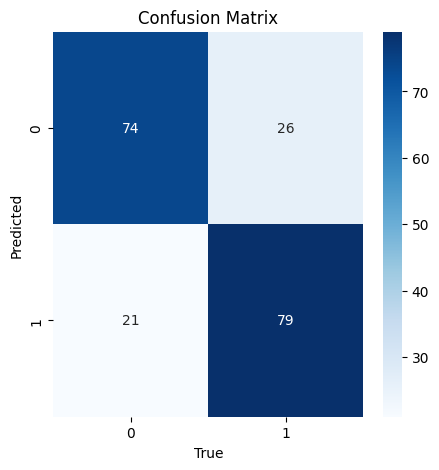

In [32]:
cm = confusion_matrix(y_test, y_pred_classes) # 오차행렬

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

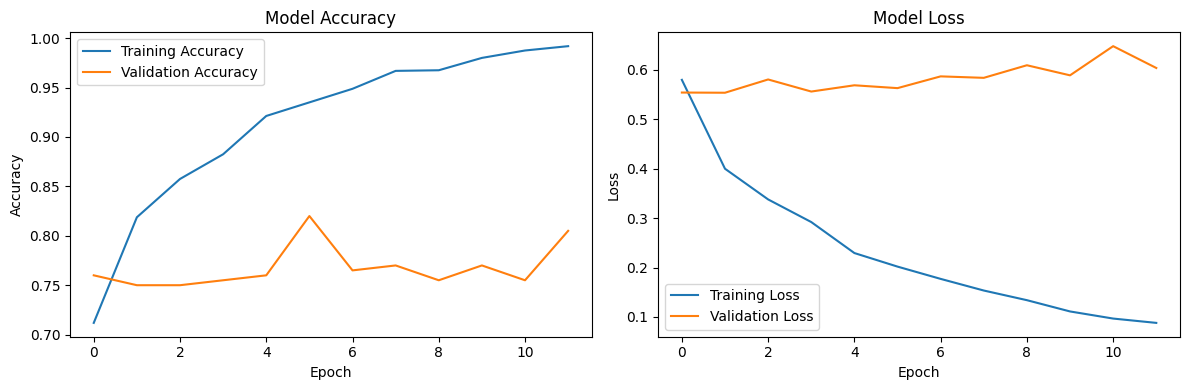

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

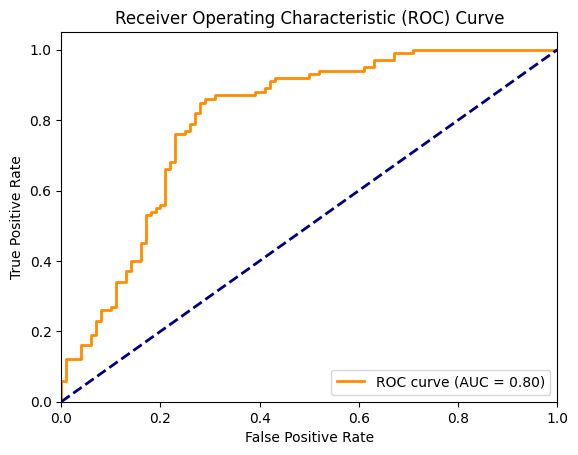

In [34]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()